## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env import TicTacToe # - import your class from environment file
import collections
import numpy as np
import random     
import pickle
import time as tick
from matplotlib import pyplot as plt
from tqdm import tqdm
np.random.seed(42)
random.seed(0)

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time):
    max_epsilon = 1.0
    min_epsilon = 0.001

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time)
    z = np.random.random()       
    if z > epsilon:
        action = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)
    else:
        action = random.sample(valid_actions(state),1)[0]   
    
    return action



#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [7]:
# Initialise states to be tracked
def initialise_tracking_states():
    # Lets choose some states to track q-value convergence
    sample_q_values = [('x-3-x-x-x-6-x-x-x',(0,1)),
                       ('x-1-x-x-x-x-8-x-x',(2,9)),
                       ('x-x-x-x-6-x-x-x-5',(2,7)),
                       ('x-x-x-x-9-x-6-x-x',(1,7)),
                       ('x-5-x-2-x-x-4-7-x',(0,9)),
                       ('9-x-5-x-x-x-8-x-4',(1,3)),
                       ('2-7-x-x-6-x-x-3-x',(8,5)),
                       ('9-x-x-x-x-2-x-x-x',(2,5)),
                       ('x-x-7-x-x-x-x-x-2',(1,5)),
                       ('5-x-x-x-x-6-x-x-x',(4,9)),
                       ('4-x-x-6-x-x-3-1-x',(8,5)),
                       ('5-x-8-x-x-6-3-x-x',(3,1)),
                       ('x-6-5-x-2-x-x-3-x',(0,7)),
                       ('7-x-5-x-2-x-x-x-6',(1,3))]
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []
        


In [8]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
# Lets define function to track states
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
# Lets initialise tracking states
initialise_tracking_states()

In [11]:
# Lets check if its initialized properly
States_track

defaultdict(dict,
            {'2-7-x-x-6-x-x-3-x': {(8, 5): []},
             '4-x-x-6-x-x-3-1-x': {(8, 5): []},
             '5-x-8-x-x-6-3-x-x': {(3, 1): []},
             '5-x-x-x-x-6-x-x-x': {(4, 9): []},
             '7-x-5-x-2-x-x-x-6': {(1, 3): []},
             '9-x-5-x-x-x-8-x-4': {(1, 3): []},
             '9-x-x-x-x-2-x-x-x': {(2, 5): []},
             'x-1-x-x-x-x-8-x-x': {(2, 9): []},
             'x-3-x-x-x-6-x-x-x': {(0, 1): []},
             'x-5-x-2-x-x-4-7-x': {(0, 9): []},
             'x-6-5-x-2-x-x-3-x': {(0, 7): []},
             'x-x-7-x-x-x-x-x-2': {(1, 5): []},
             'x-x-x-x-6-x-x-x-5': {(2, 7): []},
             'x-x-x-x-9-x-6-x-x': {(1, 7): []}})

#### Define hyperparameters  

In [12]:
# Lets define episodes as 6M
EPISODES = 6000000
# lets define 60,00,00 as checkpoint to print agent win%, env% and tie%
checkpoint= 600000
STEPS = 30                 #for 30 days
#lets define learning rate as 0.2. This value was decided after tuning hyperparameters
LR = 0.2                 #learning rate
# Lets define discount factor . This was also decided after tuning hyperparameters
GAMMA = 0.91

threshold = 2000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
#threshold = 1
policy_threshold = 30000    #every these many episodes, the Q-dict will be updated
#policy_threshold = 3

### Q-update loop

In [13]:
# Define Environment
env = TicTacToe()
# initialise reward
reward = 0
# Get Current state
curr_state = env.state
print("Initial State")
print(type(curr_state[0]))
# Add to Q Dictionary
add_to_dict(curr_state)
# initialise total reward
total_reward = 0
time_step = 0
# boolean to check if game ended
game_end = False

Initial State
<class 'float'>


In [14]:
# Lets check initial Q dictionary
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 0,
              (0, 3): 0,
              (0, 5): 0,
              (0, 7): 0,
              (0, 9): 0,
              (1, 1): 0,
              (1, 3): 0,
              (1, 5): 0,
              (1, 7): 0,
              (1, 9): 0,
              (2, 1): 0,
              (2, 3): 0,
              (2, 5): 0,
              (2, 7): 0,
              (2, 9): 0,
              (3, 1): 0,
              (3, 3): 0,
              (3, 5): 0,
              (3, 7): 0,
              (3, 9): 0,
              (4, 1): 0,
              (4, 3): 0,
              (4, 5): 0,
              (4, 7): 0,
              (4, 9): 0,
              (5, 1): 0,
              (5, 3): 0,
              (5, 5): 0,
              (5, 7): 0,
              (5, 9): 0,
              (6, 1): 0,
              (6, 3): 0,
              (6, 5): 0,
              (6, 7): 0,
              (6, 9): 0,
              (7, 1): 0,
              (7, 3): 0,
              (7, 5): 0,
           

# Modeling


In [15]:
# Start the clock
start_time = tick.time()
# to calculate agent win %
agent_win=0
# to calculate environment win %
env_win=0
# to calculate match tie %
match_tie=0
# lets define 60,00,00 as checkpoint to print agent win%, env% and tie%
checkpoint=600000
# to print number of episodes
ep_check=10000
for episode in tqdm(range(EPISODES)):
    
    # Define Environment
    env = TicTacToe()
    # initialize reward to maximise to 0
    reward = 0
    # Get Current state
    curr_state = env.state
    # Add to Q Dictionary
    add_to_dict(curr_state)
    # initialize total reward
    total_reward = 0
    time_step = 0
    game_end = False
    #print("game starts\n",np.matrix(curr_state).reshape((3,3)))
    # play untill game ends for the current episode
    while not game_end:
        # Get action based upon expoloration/exploitation
        curr_action = epsilon_greedy(curr_state, episode)
        
        #print("agent action",curr_action)
        # get next state, reward and if game finished, after a play
        next_state,reward,game_end = env.step(curr_state,curr_action)
        # Get Q State
        curr_q = Q_state(curr_state)
        next_q = Q_state(next_state)
        # Check if game ended
        if game_end:
            # print("reward",reward,"total reward",total_reward+reward)
            q_value_max = 0
            # Set rewards
            if reward==-10:
                env_win+=1
            elif reward==10:
                agent_win+=1
            elif reward==0:
                match_tie+=1
        else:
            # Update dictionary
            add_to_dict(next_state)
            # Get maximum valued next state 
            max_next=max(Q_dict[next_q],key=Q_dict[next_q].get)
            # Get value for maximum value
            q_value_max = Q_dict[next_q][max_next] 
            #print("reward",reward)
        # Update Q Dictionary with value based on the formula
        Q_dict[curr_q][curr_action] += LR * ((reward + (GAMMA * (q_value_max))) - Q_dict[curr_q][curr_action])
        # Update current state to next
        curr_state = next_state
        # add to total reward
        total_reward+=reward
        #print("curr_state\n",np.matrix(curr_state).reshape((3,3)))
    if (episode+1)%checkpoint==0:
        print("Number of games played ",episode+1,"agent win %",(agent_win/(episode+1))*100,"environment win %",(env_win/(episode+1))*100,"Match Tie %",(match_tie/(episode+1))*100)
    if ((episode + 1) % threshold) == 0:   
        save_tracking_states()  
elapsed_time = tick.time() - start_time
# Save Tracking States
save_obj(States_track,'States_tracked')   
# Save Q dictionary
save_obj(Q_dict,'Policy')

 10%|█         | 600083/6000000 [13:54<1:52:42, 798.49it/s]

Number of games played  600000 agent win % 29.314833333333333 environment win % 26.905666666666665 Match Tie % 43.7795


 20%|██        | 1200103/6000000 [25:24<1:23:18, 960.20it/s]

Number of games played  1200000 agent win % 41.56316666666667 environment win % 22.794416666666667 Match Tie % 35.64241666666666


 30%|███       | 1800130/6000000 [35:35<1:09:05, 1013.03it/s]

Number of games played  1800000 agent win % 51.98044444444444 environment win % 19.22588888888889 Match Tie % 28.793666666666667


 40%|████      | 2400164/6000000 [45:03<55:43, 1076.77it/s]

Number of games played  2400000 agent win % 59.64879166666667 environment win % 16.466 Match Tie % 23.88520833333333


 50%|█████     | 3000151/6000000 [54:13<44:55, 1112.75it/s]

Number of games played  3000000 agent win % 65.24013333333333 environment win % 14.327666666666666 Match Tie % 20.4322


 60%|██████    | 3600146/6000000 [1:03:12<35:37, 1122.95it/s]

Number of games played  3600000 agent win % 69.48380555555556 environment win % 12.573361111111112 Match Tie % 17.942833333333333


 70%|███████   | 4200190/6000000 [1:12:13<26:43, 1122.35it/s]

Number of games played  4200000 agent win % 72.85397619047619 environment win % 11.12452380952381 Match Tie % 16.0215


 80%|████████  | 4800164/6000000 [1:21:11<18:20, 1090.58it/s]

Number of games played  4800000 agent win % 75.61375 environment win % 9.892541666666666 Match Tie % 14.493708333333332


 90%|█████████ | 5400116/6000000 [1:30:19<09:25, 1061.73it/s]

Number of games played  5400000 agent win % 77.84783333333334 environment win % 8.881518518518519 Match Tie % 13.270648148148148


100%|██████████| 6000000/6000000 [1:39:24<00:00, 1005.94it/s]


Number of games played  6000000 agent win % 79.62351666666667 environment win % 8.080866666666667 Match Tie % 12.295616666666668


### Observation
- We see that agent has learnt the numerical tic tac toe game fairly with win percentage of almost 80% . 
- We also see that match was tied 12% which also tells that agent has learnt the game accurately. 

#### Check the Q-dictionary

In [2]:
# Uncomment the following code to read Q Dictionary from pickle files

with open('Policy.pkl', 'rb') as handle:
    Q_dict = pickle.load(handle)
    
with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle) 

In [ ]:
# Lets check the Q Dictionary
Q_dict.keys()

In [3]:
# lets check how many states
len(Q_dict)

1295415

In [28]:
# lets check the states
States_track.keys()

dict_keys(['x-3-x-x-x-6-x-x-x', 'x-1-x-x-x-x-8-x-x', 'x-x-x-x-6-x-x-x-5', 'x-x-x-x-9-x-6-x-x', 'x-5-x-2-x-x-4-7-x', '9-x-5-x-x-x-8-x-4', '2-7-x-x-6-x-x-3-x', '9-x-x-x-x-2-x-x-x', 'x-x-7-x-x-x-x-x-2', '5-x-x-x-x-6-x-x-x', '4-x-x-6-x-x-3-1-x', '5-x-8-x-x-6-3-x-x', 'x-6-5-x-2-x-x-3-x', '7-x-5-x-2-x-x-x-6', '9-x-x-x-x-x-4-7-x', 'x-5-x-x-x-x-4-7-x'])

In [4]:
# Lets check the action for 'x-3-x-x-x-6-x-x-x'
States_track['x-3-x-x-x-6-x-x-x'].keys()

dict_keys([(0, 1)])

In [19]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
Q_dict['x-3-x-x-x-6-x-x-x']

{(0, 1): -0.931280523264,
 (0, 5): -0.38074764595009936,
 (0, 7): -0.6775104725622503,
 (0, 9): -0.6311642579674671,
 (2, 1): -0.9774820018631475,
 (2, 5): 0.7510259313008518,
 (2, 7): -0.4487509421511474,
 (2, 9): -0.9450244186112,
 (3, 1): -1.3931606656000002,
 (3, 5): 0.1035521167360004,
 (3, 7): -1.7230489645314653,
 (3, 9): -0.9450244186112,
 (4, 1): -0.931280523264,
 (4, 5): -0.9774820018631475,
 (4, 7): -1.3743009205447942,
 (4, 9): -0.5810715744794088,
 (6, 1): -0.89022225408,
 (6, 5): -0.1891968000455343,
 (6, 7): -0.925731425517568,
 (6, 9): -0.5226317323924144,
 (7, 1): -0.576937227911168,
 (7, 5): -0.8367207188889599,
 (7, 7): -0.7975979138649948,
 (7, 9): 4.025312355645897,
 (8, 1): -0.9450244186112,
 (8, 5): -1.3682639879631453,
 (8, 7): -1.3881864715627514,
 (8, 9): -0.8257262060066115}

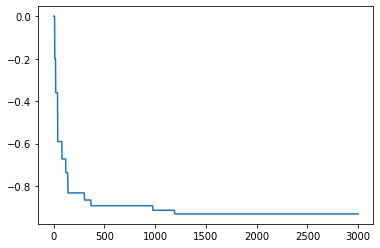

In [5]:
# lets plot the convergence
t1=States_track['x-3-x-x-x-6-x-x-x'][(0,1)]
plt.plot(np.asarray(range(0, len(t1))),np.asarray(t1))
plt.show()

# Q-values convergence

#### Check the states tracked for Q-values convergence
(non-evaluative)

### All Q-values convergence

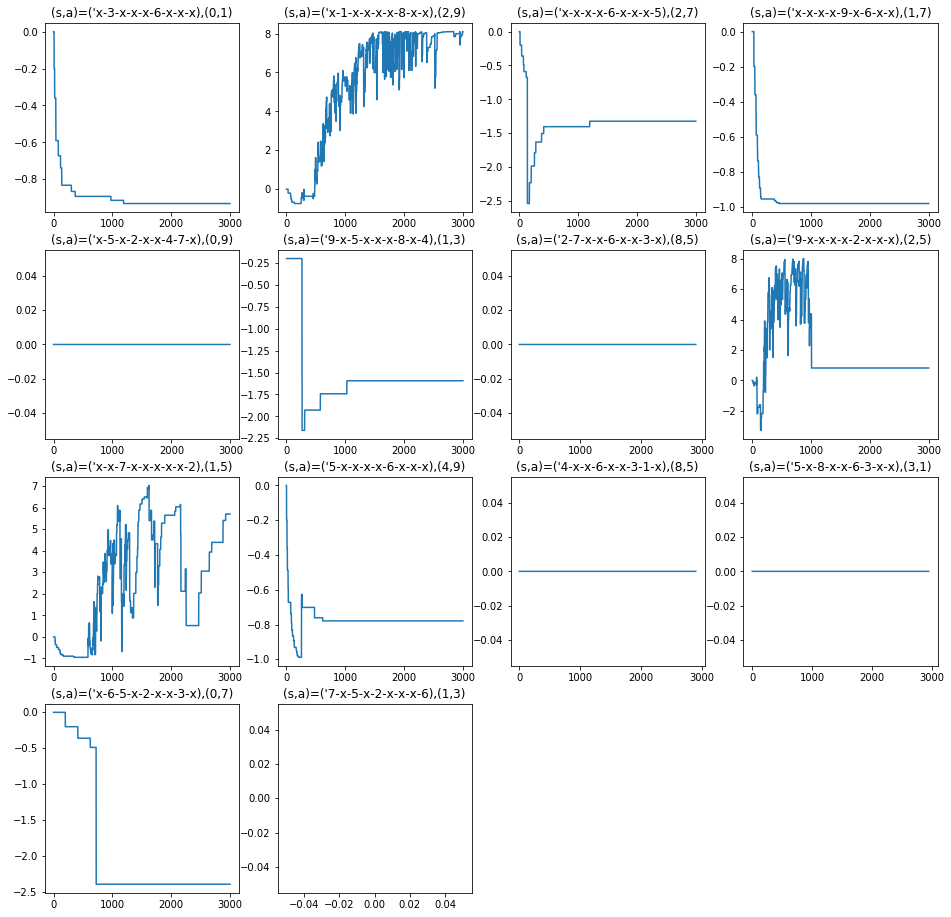

In [6]:
# Lets print state value convergence for all states tracked
# initialise row count for subplots
r_count=1
# set figure size
plt.figure(0, figsize=(16,16))
# For all states, print the state value convergence
for i in list(States_track.keys()):
    act = list(States_track[i].keys())
    t = States_track[i][act[0]]
    plt.subplot(4,4,r_count)
    r_count+=1
    plt.title("(s,a)=('"+i+"),("+str(act[0][0])+","+str(act[0][1])+")")
    plt.plot(np.asarray(range(0, len(t))),np.asarray(t))

### Observation
- We see that for most of the states that we tracked, have converged at the end as the line has become parallel to x-axis

In [ ]:
# Write the code for plotting the graphs for state-action pairs tracked

### Best Q-values convergence
- let's pick 4 best state value convergence and plot convergence graph

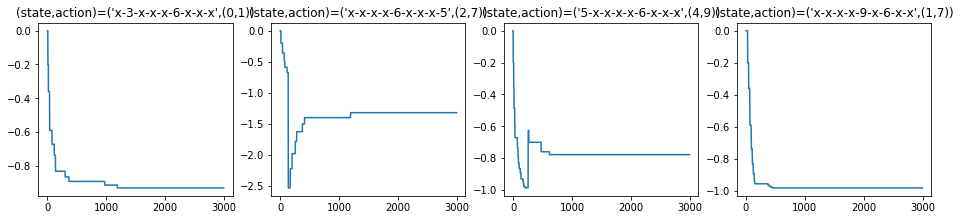

In [7]:
Q_dict['x-3-x-x-x-6-x-x-x']
plt.figure(0, figsize=(16,7))
plt.subplot(2,4,1)
t1=States_track['x-3-x-x-x-6-x-x-x'][(0,1)]
plt.title("(state,action)=('x-3-x-x-x-6-x-x-x',(0,1))")
plt.plot(np.asarray(range(0, len(t1))),np.asarray(t1))

plt.subplot(2,4,2)
t2=States_track['x-x-x-x-6-x-x-x-5'][(2,7)]
plt.title("(state,action)=('x-x-x-x-6-x-x-x-5',(2,7))")
plt.plot(np.asarray(range(0, len(t2))),np.asarray(t2))

plt.subplot(2,4,3)
t3=States_track['5-x-x-x-x-6-x-x-x'][(4,9)]
plt.title("(state,action)=('5-x-x-x-x-6-x-x-x',(4,9))")
plt.plot(np.asarray(range(0, len(t3))),np.asarray(t3))

plt.subplot(2,4,4)
t4=States_track['x-x-x-x-9-x-6-x-x'][(1,7)]
plt.title("(state,action)=('x-x-x-x-9-x-6-x-x',(1,7))")
plt.plot(np.asarray(range(0, len(t4))),np.asarray(t4))

plt.show()

### Observation
- As we in the graphs above, the q values have converged at the end as the line has become parallel. 

### Epsilon - decay check

In [26]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

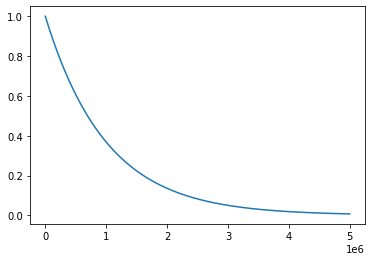

In [27]:
plt.plot(time, epsilon)
plt.show()